In [1]:
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update("jax_default_device",jax.devices()[1])
import jax.numpy as jnp
import diffrax

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jax.random import key

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier,NoSparsifier
from pysindy import STLSQ,SR3,MIOSR
import jsindy
from numpy import loadtxt


In [ ]:
t1 = 10
x0 = jnp.array([2,0.])
def f(t,x,args):
    return jnp.array([- 0.1*x[0]**3 + 2*x[1]**3,- 0.1*x[1]**3 -2*x[0]**3])
ode = diffrax.ODETerm(f)
step_control = diffrax.PIDController(rtol = 1e-7,atol =1e-7)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(dense = True)

sol = diffrax.diffeqsolve(ode,solver,0.,20.,dt0 = 0.005,y0 = x0,saveat = save_at,stepsize_controller=step_control)

dt_train = 0.05

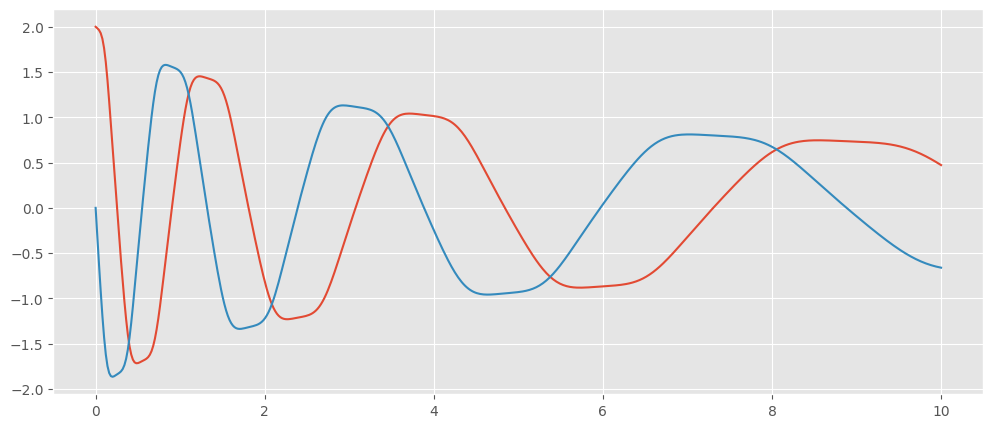

In [4]:
t_grid = jnp.linspace(0,t1,500)
x_vals = jax.vmap(sol.evaluate)(t_grid)

plt.figure(figsize=(12,5))
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])

In [24]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.,feature_map=PolyLib(3))
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=False,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  10.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    # STLSQ(0.05,20.)
    SR3(reg_weight_lam=1.,regularizer='L1',relax_coeff_nu=0.5,normalize_columns=True,max_iter = 1000)
    )

# sparsifier = NoSparsifier()

optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)


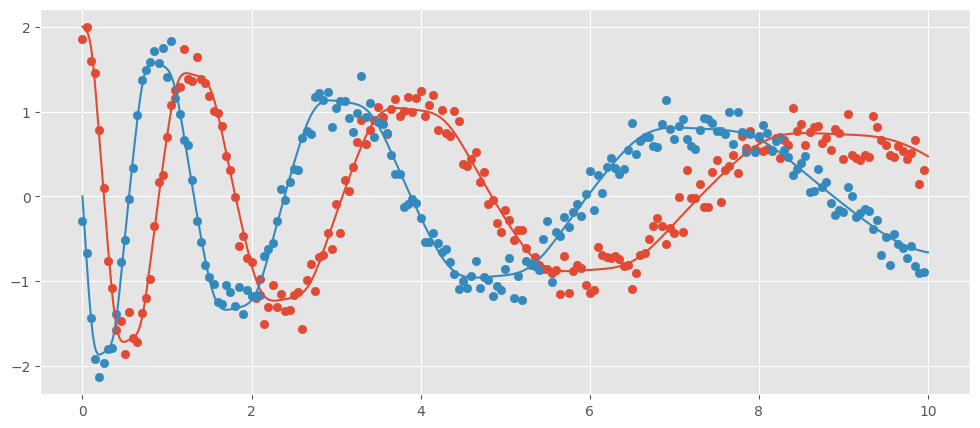

In [29]:
t_train = jnp.arange(0,t1,dt_train)
x_train_true = jax.vmap(sol.evaluate)(t_train)

noise_sigma = 0.16
x_train = x_train_true + noise_sigma * jax.random.normal(key(111),(x_train_true.shape))

plt.figure(figsize=(12,5))
plt.scatter(t_train,x_train[:,0])
plt.scatter(t_train,x_train[:,1])
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])
plt.show()


In [30]:

t_colloc,w_colloc = jsindy.util.get_collocation_points_weights(t_train,500,bleedout_nodes=5)
model.fit(
    t_train,
    x_train,
    t_colloc = t_colloc,
    w_colloc = w_colloc
)

model.print()

{'show_progress': False, 'sigma2_est': Array(0.02542737, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
(x)' = -0.126 x^3 + 1.947 y^3
(y)' = -0.090 x^2 + -1.979 x^3 + -0.121 x y^2 + -0.071 y^3


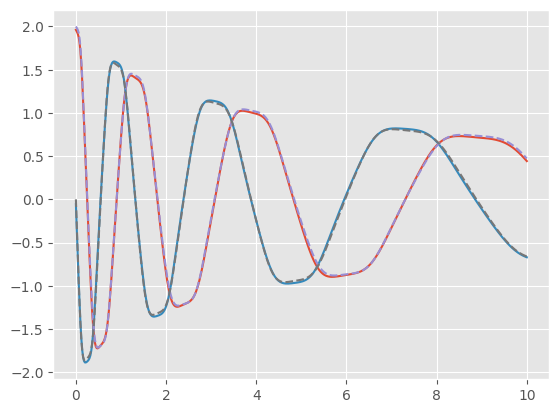

In [31]:
plt.plot(t_grid,model.predict_state(t_grid))
plt.plot(t_grid,x_vals,ls = '--')

In [7]:
true_theta = jnp.array(
    [[ 0.        ,  0.        ],
    [ 0.        , 0.    ],
    [0. ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [-0.1, -2.],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 2., -0.1]])

In [8]:
noise_vals = jnp.array([0.02,0.04,0.08,0.16,0.32,0.64])


In [ ]:
all_xpreds = []
all_xdot_preds = []
all_thetas = []


num_repeats = 32
noise_vals = jnp.array([0.02,0.04,0.08,0.16,0.32,0.64])

all_theta_errors = jnp.zeros((num_repeats,len(noise_vals)))
all_x_errors = jnp.zeros((num_repeats,len(noise_vals)))
all_keys = jax.random.split(key(3184),num_repeats)


for repetition in range(num_repeats):
    print(repetition)
    for s,noise_sigma in enumerate(noise_vals):
        x_train = x_train_true + noise_sigma * jax.random.normal(all_keys[repetition],(x_train_true.shape))
        model.fit(t_train,x_train)
        model.print()

        xpred = model.predict_state(t_grid)
        all_theta_errors = all_theta_errors.at[repetition,s].set(
            jnp.linalg.norm(true_theta - model.theta)/jnp.linalg.norm(true_theta))
        
        all_x_errors = all_x_errors.at[repetition,s].set(
            jnp.sqrt(jnp.mean((x_vals - xpred)**2))/jnp.std(x_vals))
    
        # all_xpreds.append(model.predict_state(t_grid))
        # all_xdot_preds.append(model.traj_model.derivative(t_grid,model.z))
        # all_thetas.append(model.theta)

        




0
{'show_progress': False, 'sigma2_est': Array(0.00048178, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 1.994 y^3
(y)' = -2.002 x^3 + -0.094 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00169942, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.073 x^3 + -0.078 x y^2 + 1.987 y^3
(y)' = -2.005 x^3 + -0.120 x^2 y + -0.061 y^3
{'show_progress': False, 'sigma2_est': Array(0.00649695, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.266 x y^2 + 1.942 y^3
(y)' = -1.983 x^3 + -0.334 x^2 y + -0.122 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02611688, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.246 x y^2 + 1.889 y^3
(y)' = -1.964 x^3 + -0.356 x^2 y + -0.220 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10347525, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.193 x^3 + -0.505 x y^2 + 1.798 y^3
(y)' = -0.106 x^2 + -1.947 x^3 + -0.692 x^2 y + -0.41

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00045725, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.103 x^3 + 2.009 y^3
(y)' = -1.994 x^3 + -0.097 y^3
{'show_progress': False, 'sigma2_est': Array(0.00174037, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.101 x^3 + 0.124 x^2 y + 1.954 y^3
(y)' = -1.929 x^3 + -0.126 x y^2 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00706377, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.199 x^3 + 0.316 x^2 y + 1.880 y^3
(y)' = -1.828 x^3 + -0.314 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02606644, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.198 x^3 + 0.471 x^2 y + 1.850 y^3
(y)' = -0.107 x^2 + -1.738 x^3 + -0.443 x y^2
{'show_progress': False, 'sigm

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00045319, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 1.999 y^3
(y)' = -2.000 x^3 + -0.091 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00170318, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.119 x^3 + 1.998 y^3
(y)' = -1.999 x^3 + -0.080 y^3
{'show_progress': False, 'sigma2_est': Array(0.00671868, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.153 x^3 + 0.334 x^2 y + -0.143 x y^2 + 1.848 y^3
(y)' = -1.858 x^3 + -0.280 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02464847, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.152 x^3 + 0.467 x^2 y + -0.149 x y^2 + 1.791 y^3
(y)' = -1.812 x^3 + -0.359 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09490399, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.151 x^3 + 0.267 x^2 y + -0.167 x y^2 + 1.898 y^3
(y)' = 0.128 x^2 + -1.962 x^3
{'show_progress': False, 'sigma2_est': Array(0.37868869, dtype=float64), 'data_weight': 1.0, 'colloc_w

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00056585, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 0.100 x^2 y + 1.948 y^3
(y)' = -1.952 x^3 + -0.110 x y^2 + -0.095 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.0020802, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 0.211 x^2 y + 1.892 y^3
(y)' = -1.901 x^3 + -0.229 x y^2 + -0.091 y^3
{'show_progress': False, 'sigma2_est': Array(0.00787417, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.118 x^3 + 0.488 x^2 y + 1.762 y^3
(y)' = -1.778 x^3 + -0.526 x y^2 + -0.082 y^3
{'show_progress': False, 'sigma2_est': Array(0.0289143, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.111 x^3 + 0.653 x^2 y + 1.686 y^3
(y)' = -1.713 x^3 + -0.714 x y^2 + -0.088 y^3
{'show_progress': False, 'sigma2_est': Array(0.11220231, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.127 x^2 + -0.180 y^2 + -0.093 x^3 + 0.770 x^2 y + 1.641 y^3
(y)' = -0.2

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00054431, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 1.994 y^3
(y)' = -2.020 x^3 + -0.092 y^3
{'show_progress': False, 'sigma2_est': Array(0.00210389, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.118 x^3 + 1.988 y^3
(y)' = -2.040 x^3 + -0.083 y^3
{'show_progress': False, 'sigma2_est': Array(0.00809221, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.205 x^3 + 1.977 y^3
(y)' = -2.079 x^3
{'show_progress': False, 'sigma2_est': Array(0.03008296, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.211 x^3 + 1.951 y^3
(y)' = -2.164 x^3
{'show_progress': False, 'sigma2_est': Array(0.11638576, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.6

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1904.0142126924522
{'show_progress': False, 'sigma2_est': Array(0.00042356, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 0.089 x^2 y + 1.968 y^3
(y)' = -1.951 x^3 + -0.090 x y^2 + -0.095 y^3
{'show_progress': False, 'sigma2_est': Array(0.00153417, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.108 x^3 + 0.147 x^2 y + 1.952 y^3
(y)' = -1.918 x^3 + -0.147 x y^2 + -0.093 y^3
{'show_progress': False, 'sigma2_est': Array(0.00633188, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.120 x^3 + 0.422 x^2 y + 1.846 y^3
(y)' = -1.784 x^3 + -0.430 x y^2 + -0.081 y^3
{'show_progress': False, 'sigma2_est': Array(0.02368412, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.119 x^3 + 0.597 x^2 y + 1.816 y^3
(y)' = -1.693 x^3 + -0.603 x y^2 + -0.083 y^3
{'show_progr

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1898.4262140744559
{'show_progress': False, 'sigma2_est': Array(0.00042378, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 0.108 x^2 y + 1.942 y^3
(y)' = -1.953 x^3 + -0.110 x y^2 + -0.095 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00161892, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 0.180 x^2 y + 1.904 y^3
(y)' = -1.925 x^3 + -0.182 x y^2 + -0.093 y^3
{'show_progress': False, 'sigma2_est': Array(0.00677716, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.116 x^3 + 0.426 x^2 y + 1.782 y^3
(y)' = -1.823 x^3 + -0.431 x y^2 + -0.084 y^3
{'show_progress': False, 'sigma2_est': Array(0.02551587, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.085 x^3 + 0.606 x^2 y + 1.690 y^3
(y)' = -1.769 x^3 + -0.126 x^2 y + -0.609 x y^2 + -0.073 y^3
{'show_progress': False, 'sigma2_est': Array(0.09973311, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.095 x^3 + 0.763 x^2 y + 1.588 y^3
(y)' = 0.155 x^2 + 

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1883.728138651611
{'show_progress': False, 'sigma2_est': Array(0.00046295, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 1.989 y^3
(y)' = -2.011 x^3 + -0.090 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00167943, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.114 x^3 + 0.119 x^2 y + 1.922 y^3
(y)' = -1.968 x^3 + -0.101 x y^2 + -0.085 y^3
{'show_progress': False, 'sigma2_est': Array(0.00664077, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.128 x^3 + 0.287 x^2 y + 1.824 y^3
(y)' = -1.914 x^3 + -0.254 x y^2 + -0.070 y^3
{'show_progress': False, 'sigma2_est': Array(0.02482634, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.205 x^3 + 0.385 x^2 y + 1.746 y^3
(y)' = -0.046 x + -1.888 x^3 + -0.283 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09602228, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.212 x^3 + 0.476 x^2 y + 1.632 y^3
(y)' = -0.115 x + -1.911 x^3 + -0.252 x y^2
{'show_progress': False, 'sigma2_est

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00049227, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.111 x^3 + 1.984 y^3
(y)' = -2.007 x^3 + -0.088 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00187262, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.120 x^3 + 0.131 x^2 y + 1.910 y^3
(y)' = -1.958 x^3 + -0.102 x y^2 + -0.079 y^3
{'show_progress': False, 'sigma2_est': Array(0.00720566, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.138 x^3 + 0.284 x^2 y + 1.813 y^3
(y)' = -1.905 x^3 + -0.229 x y^2 + -0.062 y^3
{'show_progress': False, 'sigma2_est': Array(0.02686358, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.204 x^3 + 0.314 x^2 y + 1.755 y^3
(y)' = -1.933 x^3 + -0.188 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10434212, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = 0.126 x^2 + -0.117 y^2 + -0.209 x^3 + 0.272 x^2 y + 1.698 y^3
(y)' = -0.221 x y + -2.049 x^3
{'show_progress': False, 'sigma2_es

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1843.7949992056333
{'show_progress': False, 'sigma2_est': Array(0.0005626, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 0.108 x^2 y + 1.935 y^3
(y)' = -1.950 x^3 + -0.119 x y^2 + -0.095 y^3
{'show_progress': False, 'sigma2_est': Array(0.00209367, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 0.205 x^2 y + 1.878 y^3
(y)' = -1.907 x^3 + -0.225 x y^2 + -0.091 y^3
{'show_progress': False, 'sigma2_est': Array(0.00806385, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.091 x^3 + 0.568 x^2 y + 1.693 y^3
(y)' = -1.748 x^3 + -0.118 x^2 y + -0.622 x y^2 + -0.070 y^3
{'show_progress': False, 'sigma2_est': Array(0.02930262, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.097 x^2 + 0.625 x^2 y + 1.640 y^3
(y)' = 0.163 x y + -1.748 x^3 + -0.316 x^2 y

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1516.2486699965007
{'show_progress': False, 'sigma2_est': Array(0.00210383, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.096 x^3 + 0.227 x^2 y + 1.909 y^3
(y)' = -1.895 x^3 + -0.231 x y^2 + -0.105 y^3
{'show_progress': False, 'sigma2_est': Array(0.00767304, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.088 x^3 + 0.427 x^2 y + 1.836 y^3
(y)' = -1.811 x^3 + -0.434 x y^2 + -0.114 y^3
{'show_progress': False, 'sigma2_est': Array(0.02842261, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.082 x^3 + 0.562 x^2 y + 0.280 x y^2 + 1.834 y^3
(y)' = -0.038 x + -1.739 x^3 + -0.546 x y^2 + -0.219 y^3
{'show_progress': False, 'sigma2_est': Array(0.11044677, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.020 y + 0.156 x^2 + 0.8

/home/owlx/miniconda3/envs/jsindy/lib/python3.13/site-packages/pysindy/optimizers/sr3.py:374: ConvergenceWarning: SR3 did not converge after 1000 iterations.
  warnings.warn(
/home/owlx/miniconda3/envs/jsindy/lib/python3.13/site-packages/pysindy/optimizers/sr3.py:374: ConvergenceWarning: SR3 did not converge after 1000 iterations.
  warnings.warn(
/home/owlx/miniconda3/envs/jsindy/lib/python3.13/site-packages/pysindy/optimizers/sr3.py:374: ConvergenceWarning: SR3 did not converge after 1000 iterations.
  warnings.warn(
/home/owlx/miniconda3/envs/jsindy/lib/python3.13/site-packages/pysindy/optimizers/sr3.py:374: ConvergenceWarning: SR3 did not converge after 1000 iterations.
  warnings.warn(


(x)' = 0.207 x + -87.072 y + 0.521 x y + 1.323 y^2 + 81.078 x^2 y + 5.538 x y^2 + 61.094 y^3
(y)' = 114.167 x + -0.075 y + -0.592 x^2 + -1.587 x y + -106.144 x^3 + -7.676 x^2 y + -80.273 x y^2
13
{'show_progress': False, 'sigma2_est': Array(0.000477, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 1.992 y^3
(y)' = -1.996 x^3 + -0.094 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00174088, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 1.984 y^3
(y)' = -1.991 x^3 + -0.093 y^3
{'show_progress': False, 'sigma2_est': Array(0.00702538, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.197 x^3 + 0.094 x^2 y + 1.919 y^3
(y)' = -1.934 x^3 + -0.097 x y^2
{'show_progress': False, 'sigma2_est': Array(0.0275837, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.155 x^3 + 0.254 x^2 y + -0.119 x y^2 + 1.809 y^3
(y)' = -1.839 x^3 + -0.273 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10645261, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.361 x y + -0.126 y^2 + 0.176 x^2 y + -0.155 x y^2 + 1.804 y^3
(y)' = -0.251 x^2 + 0.129 y^2 + -1.825 x^3 + -0.402 x^2 y + -0.176 x y^2
{'show_progress': False, 'sigma2_est': Array(0.41938716, dtype=float64), 'data_weight': 1.0, 'colloc_weigh

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00051649, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.111 x^3 + 0.084 x^2 y + 1.951 y^3
(y)' = -1.961 x^3 + -0.083 x y^2 + -0.089 y^3
{'show_progress': False, 'sigma2_est': Array(0.00188006, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.122 x^3 + 0.188 x^2 y + 1.894 y^3
(y)' = -1.912 x^3 + -0.188 x y^2 + -0.078 y^3
{'show_progress': False, 'sigma2_est': Array(0.00692068, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.200 x^3 + 0.344 x^2 y + 1.810 y^3
(y)' = -1.842 x^3 + -0.340 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02558295, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.200 x^3 + 0.404 x^2 y + 1.756 y^3
(y)' = -1.822 x^3 + -0.392 x y^2
{'show_progres

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00042449, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 1.999 y^3
(y)' = -1.994 x^3 + -0.093 y^3
{'show_progress': False, 'sigma2_est': Array(0.00156972, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.107 x^3 + 1.998 y^3
(y)' = -1.988 x^3 + -0.092 y^3
{'show_progress': False, 'sigma2_est': Array(0.00689081, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.119 x^3 + 0.333 x^2 y + 1.844 y^3
(y)' = -1.829 x^3 + -0.294 x y^2 + -0.079 y^3
{'show_progress': False, 'sigma2_est': Array(0.02562306, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = 0.174 y^2 + -0.196 x^3 + 0.485 x^2 y + 1.781 y^3
(y)' = -1.749 x^3 + -0.393 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09751173, dtype=float64), 'data_weight': 1.0

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00184807, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.107 x^3 + 0.230 x^2 y + 1.900 y^3
(y)' = -1.905 x^3 + -0.196 x y^2 + -0.094 y^3
{'show_progress': False, 'sigma2_est': Array(0.00702664, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.112 x^3 + 0.497 x^2 y + 1.789 y^3
(y)' = -1.798 x^3 + -0.433 x y^2 + -0.089 y^3
{'show_progress': False, 'sigma2_est': Array(0.02624022, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.735 x^2 y + -0.280 x y^2 + 1.712 y^3
(y)' = -0.037 x + -1.702 x^3 + -0.329 x^2 y + -0.584 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10315568, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.137 x^2 + -0.357 x y + 1.088 x^2 y + -0.361 x y^2 + 1.648 y^3
(y)' = -0.137 x + -0.122 x^2 + 0.17

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1907.486163228241
{'show_progress': False, 'sigma2_est': Array(0.0004465, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.111 x^3 + 0.094 x^2 y + 1.965 y^3
(y)' = -1.946 x^3 + -0.093 x y^2 + -0.089 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.0015964, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.121 x^3 + 0.179 x^2 y + 1.936 y^3
(y)' = -1.897 x^3 + -0.177 x y^2 + -0.079 y^3
{'show_progress': False, 'sigma2_est': Array(0.00612226, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.198 x^3 + 0.375 x^2 y + 1.868 y^3
(y)' = -1.790 x^3 + -0.372 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02310588, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.196 x^3 + 0.477 x^2 y + 1.868 y^3
(y)' = -1.714 x^3 + -0.469 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09070909, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.124 y^2 + -0.139 x^3 + 0.452 x^2 y + 1.965 y^3
(y)' = -0.156 x^2 + -1.634 x^3 + -0.157 x^2 y + -

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00054609, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.048 x^3 + 1.946 y^3
(y)' = -1.950 x^3 + -0.033 y^3
{'show_progress': False, 'sigma2_est': Array(0.00200459, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 2.016 y^3
(y)' = -2.016 x^3 + -0.096 y^3
{'show_progress': False, 'sigma2_est': Array(0.00842653, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.205 x^3 + 0.279 x^2 y + 1.916 y^3
(y)' = -1.916 x^3 + -0.204 x y^2
{'show_progress': False, 'sigma2_est': Array(0.03080899, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.210 x^3 + 0.355 x^2 y + 1.931 y^3
(y)' = -1.931 x^3 + -0.203 x y^2
{'show_progress': False, 'sigma2_est': Array(0.11842806, dtype=float64),

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00048622, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 0.089 x^2 y + 1.939 y^3
(y)' = -1.972 x^3 + -0.099 x y^2 + -0.095 y^3
{'show_progress': False, 'sigma2_est': Array(0.0017557, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.106 x^3 + 0.133 x^2 y + 1.901 y^3
(y)' = -1.967 x^3 + -0.151 x y^2 + -0.095 y^3
{'show_progress': False, 'sigma2_est': Array(0.00707648, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.114 x^3 + 0.340 x^2 y + 1.775 y^3
(y)' = -1.902 x^3 + -0.375 x y^2 + -0.087 y^3
{'show_progress': False, 'sigma2_est': Array(0.02631818, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.115 x^3 + 0.481 x^2 y + 1.651 y^3
(y)' = 0.170 x^2 + -1.925 x^3 + -0.539 x y^2 + -0.088 y^3
{'show_progress': Fal

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00048547, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 1.995 y^3
(y)' = -2.005 x^3 + -0.095 y^3
{'show_progress': False, 'sigma2_est': Array(0.00180329, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.108 x^3 + 0.124 x^2 y + 1.928 y^3
(y)' = -1.950 x^3 + -0.124 x y^2 + -0.093 y^3
{'show_progress': False, 'sigma2_est': Array(0.00699624, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.117 x^3 + 0.304 x^2 y + 1.834 y^3
(y)' = -1.875 x^3 + -0.303 x y^2 + -0.083 y^3
{'show_progress': False, 'sigma2_est': Array(0.02598748, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.072 y + -0.109 x^3 + 0.330 x^2 y + 1.742 y^3
(y)' = -0.115 x^2 + -1.861 x^3 + -0.360 x y^2 + -0.09

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.0017637, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.107 x^3 + 0.171 x^2 y + 1.905 y^3
(y)' = -1.940 x^3 + -0.146 x y^2 + -0.093 y^3
{'show_progress': False, 'sigma2_est': Array(0.00700209, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.113 x^3 + 0.366 x^2 y + 1.803 y^3
(y)' = -1.871 x^3 + -0.316 x y^2 + -0.087 y^3
{'show_progress': False, 'sigma2_est': Array(0.02633591, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.081 y + -0.206 x^3 + 0.468 x^2 y + 1.666 y^3
(y)' = -1.848 x^3 + -0.397 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10138492, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.233 y + -0.113 x^2 + -0.150 x^3 + 0.466 x^2 y + 1.480 y^3
(y)' = 0.130 x^

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1871.683664807947
{'show_progress': False, 'sigma2_est': Array(0.00049969, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 0.106 x^2 y + 1.945 y^3
(y)' = -1.963 x^3 + -0.106 x y^2 + -0.091 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00182198, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.118 x^3 + 0.216 x^2 y + 1.890 y^3
(y)' = -1.926 x^3 + -0.217 x y^2 + -0.083 y^3
{'show_progress': False, 'sigma2_est': Array(0.00675025, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.204 x^3 + 0.403 x^2 y + 1.799 y^3
(y)' = 0.092 x^2 + -1.877 x^3 + -0.400 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02473111, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.204 x y + -0.208 x^3 + 0.552 x^2 y + 1.720 y^3
(y)' = 0.282 x^2 + -0.123 y^2 + -1.892 x^3 + -0.528 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09614899, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.177 x^2 + 0.461 x y + 0.356 y^2 + -0.223 x^3 + 0.794 x^2 y + 1.612 y^3
(y)' = -0.072 x + 

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1851.8110742376616
{'show_progress': False, 'sigma2_est': Array(0.00047124, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 1.998 y^3
(y)' = -1.989 x^3 + -0.090 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00188083, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.120 x^3 + 1.997 y^3
(y)' = -1.978 x^3 + -0.078 y^3
{'show_progress': False, 'sigma2_est': Array(0.00737189, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.196 x^3 + 0.104 x^2 y + 1.946 y^3
(y)' = -1.908 x^3 + -0.089 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02761206, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.192 x^3 + 0.153 x^2 y + 1.917 y^3
(y)' = -1.846 x^3 + -0.130 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10609595, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.063 y + -0.407 x y + 0.224 y^2 + -0.255 x^3 + 0.223 x^2 y + 1.841 y^3
(y)' = 0.205 x y + 0.165 y^2 + -1.771 x^3 + 0.183 x^2 

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00050868, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.103 x^3 + 2.002 y^3
(y)' = -1.993 x^3 + -0.096 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1542.1388261353238
{'show_progress': False, 'sigma2_est': Array(0.00182793, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 0.141 x^2 y + 1.938 y^3
(y)' = -1.923 x^3 + -0.120 x y^2 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00706746, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.198 x^3 + 0.211 x^2 y + 1.915 y^3
(y)' = -1.881 x^3 + -0.158 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02674166, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.148 x^3 + 0.213 x^2 y + 1.928 y^3
(y)' = -1.864 x^3 + -0.142 x^2 y + -0.112 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10516467, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.142 x^3 + 0.205 x^2 y + 1.956 y^3
(y)' = -1.843 x^3 + -0.148 x^2 y
{'show_progress': False, 'sigma2_est

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1871.0472513575949
{'show_progress': False, 'sigma2_est': Array(0.00049049, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.108 x^3 + 1.998 y^3
(y)' = -2.003 x^3 + -0.092 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1538.2504199345426
{'show_progress': False, 'sigma2_est': Array(0.00178486, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.111 x^3 + 1.995 y^3
(y)' = -2.006 x^3 + -0.089 y^3
{'show_progress': False, 'sigma2_est': Array(0.00704993, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.119 x^3 + 0.218 x^2 y + 1.906 y^3
(y)' = -1.932 x^3 + -0.119 x y^2 + -0.082 y^3
{'show_progress': False, 'sigma2_est': Array(0.02699385, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.196 x^3 + 0.327 x^2 y + 0.266 x y^2 + 1.872 y^3
(y)' = -1.915 x^3 + 0.167 x^2 y + -0.135 x y^2 + -0.149 y^3
{'show_progress': False, 'sigma2_est': Array(0.10412873, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.739 x y + -0.311 x^3 + 0.379 x^2 y + 0.570 x y^2 

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00050711, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 1.997 y^3
(y)' = -1.996 x^3 + -0.095 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1516.4553792512509
{'show_progress': False, 'sigma2_est': Array(0.00190718, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.107 x^3 + 0.098 x^2 y + 1.945 y^3
(y)' = -1.946 x^3 + -0.094 x y^2 + -0.092 y^3
{'show_progress': False, 'sigma2_est': Array(0.00770375, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.124 x^3 + 0.400 x^2 y + 1.795 y^3
(y)' = -1.799 x^3 + -0.401 x y^2 + -0.074 y^3
{'show_progress': False, 'sigma2_est': Array(0.02757101, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.144 x^3 + 0.516 x^2 y + 0.230 x y^2 + 1.733 y^3
(y)' = 0.091 x^2 + -1.741 x^3 + -0.518 x y^2 + -0.130 y^3
{'show_progress': False, 'sigma2_est': Array(0.10407093, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = 0.038 1 + 0.230 x y + 0.205 y^2 + -0.262 x^3 + 0.539 x^2 y + 0.671 x 

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1849.3461661559513
{'show_progress': False, 'sigma2_est': Array(0.00053888, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.108 x^3 + 2.020 y^3
(y)' = -1.977 x^3 + -0.091 y^3
{'show_progress': False, 'sigma2_est': Array(0.00193994, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.111 x^3 + 0.102 x^2 y + 1.983 y^3
(y)' = -1.902 x^3 + -0.122 x y^2 + -0.088 y^3
{'show_progress': False, 'sigma2_est': Array(0.00727837, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.055 x^3 + 0.171 x^2 y + -0.161 x y^2 + 1.979 y^3
(y)' = -1.825 x^3 + -0.268 x^2 y + -0.221 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02721871, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.111 x^2 + 0.268 y^2 + 0.142 x^2 y + -0.200 x y^2 + 2.065 y^3
(y)' = 0.229 x y + -1.756 x^3 + -0.392 x^2 

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00055516, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.112 x^3 + 2.001 y^3
(y)' = -1.998 x^3 + -0.088 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00206762, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.119 x^3 + 0.125 x^2 y + 1.943 y^3
(y)' = -1.941 x^3 + -0.107 x y^2 + -0.081 y^3
{'show_progress': False, 'sigma2_est': Array(0.00831533, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.199 x^3 + 0.281 x^2 y + 1.872 y^3
(y)' = -1.867 x^3 + -0.245 x y^2
{'show_progress': False, 'sigma2_est': Array(0.03132582, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.073 y^2 + -0.161 x^3 + 0.456 x^2 y + -0.115 x y^2 + 1.803 y^3
(y)' = -1.793 x^3 + -0.384 x y^2
{'show_progress': False, 'sigma2_est': Array(0.12052226, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = 0.160 x^2 + -0.302 y^2 + -0.198 x^3 + 0.565 x^2 y + 1.784 y^3
(y)' = -0.274 x y + -1.753 x^3 + -0.421 x y^2
{'sho

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1858.951247374185
{'show_progress': False, 'sigma2_est': Array(0.00049891, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.104 x^3 + 1.997 y^3
(y)' = -1.993 x^3 + -0.096 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1537.304572492597
{'show_progress': False, 'sigma2_est': Array(0.00187434, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.109 x^3 + 0.177 x^2 y + 1.908 y^3
(y)' = -0.032 x + -1.879 x^3 + -0.158 x y^2 + -0.092 y^3
{'show_progress': False, 'sigma2_est': Array(0.00708048, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.114 x^3 + 0.355 x^2 y + 1.819 y^3
(y)' = -0.064 x + -1.762 x^3 + -0.318 x y^2 + -0.087 y^3
{'show_progress': False, 'sigma2_est': Array(0.02677845, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.172 x^3 + 0.579 x^2 y + 0.203 x y^2 + 1.713 y^3
(y)' = -0.139 x + -1.588 x^3 + 0.173 x^2 y + -0.498 x y^2 + -0.155 y^3
{'show_progress': False, 'sigma2_est': Array(0.1036828, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.216 x^3 + 0.769 x^2 y + 0.393 x y^2 + 1.610 y^3
(y)' = -0.349 x + 0.146 x^2 +

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00045512, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.113 x^3 + 2.007 y^3
(y)' = -2.005 x^3 + -0.088 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00163185, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.118 x^3 + 0.071 x^2 y + 1.963 y^3
(y)' = -1.962 x^3 + -0.127 x y^2 + -0.083 y^3
{'show_progress': False, 'sigma2_est': Array(0.00630367, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.201 x^3 + 1.999 y^3
(y)' = -1.990 x^3 + -0.110 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02415442, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.184 x y + 0.119 y^2 + -0.201 x^3 + 2.002 y^3
(y)' = -0.108 y^2 + -1.981 x^3 + -0.198 x y^2
{'show_progress': False, 'sigma2_est': Array(0.0941008, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = 0.351 x y + 0.249 y^2 + -0.202 x^3 + -0.195 x^2 y + 2.130 y^3
(y)' = -0.226 y^2 + -2.063 x^3 + -0.137 x y^2
{'show_progress': False, 

/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00041652, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.110 x^3 + 1.993 y^3
(y)' = -2.003 x^3 + -0.090 y^3


/home/owlx/jsindy/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1578.9036987683821
{'show_progress': False, 'sigma2_est': Array(0.00155333, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
(x)' = -0.114 x^3 + 0.118 x^2 y + 1.924 y^3
(y)' = -1.948 x^3 + -0.125 x y^2 + -0.086 y^3
{'show_progress': False, 'sigma2_est': Array(0.00627997, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.142 x^3 + 0.223 x^2 y + 1.856 y^3
(y)' = -1.902 x^3 + -0.175 x^2 y + -0.238 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02384461, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.131 x^3 + 0.367 x^2 y + 1.759 y^3
(y)' = -1.848 x^3 + -0.214 x^2 y + -0.390 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09259976, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 10000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.126 y^2 + -0.062 x^3 + 0.396 x^2 y + -0.112 x y^2 + 1.682 y^3
(y)' = -1.860 x^3 + -0.309 

In [17]:
# save arrays with filename first and use .npy extension
jnp.save('all_theta_errors.npy', all_theta_errors)
jnp.save('all_x_errors.npy', all_x_errors)

In [9]:
all_theta_errors = jnp.load('all_theta_errors.npy')
all_x_errors = jnp.load('all_x_errors.npy')

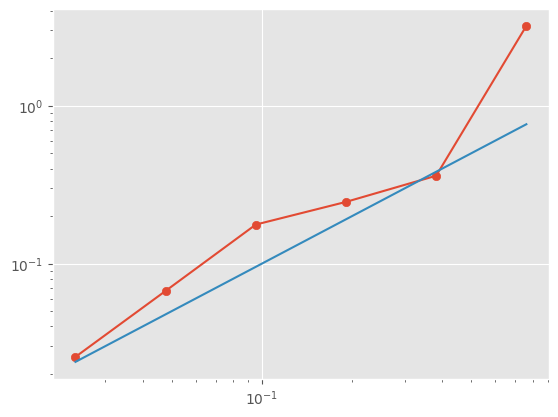

In [11]:
plt.plot(noise_vals/jnp.std(x_train_true),jnp.mean(all_theta_errors,axis=0))
plt.scatter(noise_vals/jnp.std(x_train_true),jnp.mean(all_theta_errors,axis=0))

plt.xscale('log')
plt.yscale('log')
plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))
plt.show()

# plt.plot(noise_vals/jnp.std(x_train_true),jnp.mean(all_x_errors,axis=0))
# plt.scatter(noise_vals/jnp.std(x_train_true),jnp.mean(all_x_errors,axis=0))

# plt.xscale('log')
# plt.yscale('log')
# plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))

# plt.show()


In [12]:
from pysindy import EnsembleOptimizer
from pysindy.differentiation import SmoothedFiniteDifference
import pysindy as ps
import numpy as np

In [14]:
library = ps.PolynomialLibrary(3)
optimizer = ps.STLSQ(0.09,5.)
diff_method = ps.SmoothedFiniteDifference()
ps_model = ps.SINDy(
    feature_library=library,
    optimizer=optimizer,
    differentiation_method=diff_method
    )

ps_errors = []
for noise_sigma in noise_vals:
    x_train = x_train_true + noise_sigma * jax.random.normal(key(123),(x_train_true.shape))
    ps_model.fit(np.array(x_train),np.array(t_train))
    theta = ps_model.coefficients().T

    ps_errors.append(jnp.linalg.norm(true_theta - theta)/jnp.linalg.norm(true_theta))
ps_errors = jnp.array(ps_errors)

In [18]:
odr_coef_error = jnp.array(loadtxt("coef_error.csv",delimiter = ','))
odr_x_error = jnp.array(loadtxt("x_error.csv",delimiter = ','))


odr_mean_x = jnp.mean(odr_coef_error[:-1],axis=0)
odr_mean_coef = jnp.mean(odr_x_error[:-1],axis=0)

odr_median_coef = jnp.median(odr_x_error[:-1],axis=0)

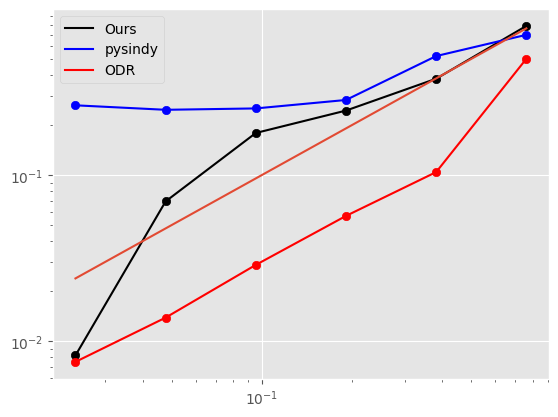

In [19]:
plt.plot(noise_vals/jnp.std(x_train_true),jnp.median(all_theta_errors,0),c='black',label = "Ours")
plt.scatter(noise_vals/jnp.std(x_train_true),jnp.median(all_theta_errors,0),c='black')

plt.plot(noise_vals/jnp.std(x_train_true),ps_errors,c='blue',label = 'pysindy')
plt.scatter(noise_vals/jnp.std(x_train_true),ps_errors,c='blue')

plt.plot(noise_vals/jnp.std(x_train_true),odr_median_coef,c='red',label = 'ODR')
plt.scatter(noise_vals/jnp.std(x_train_true),odr_median_coef,c='red')


plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))


plt.xscale('log')
plt.yscale('log')


plt.legend()
plt.show()


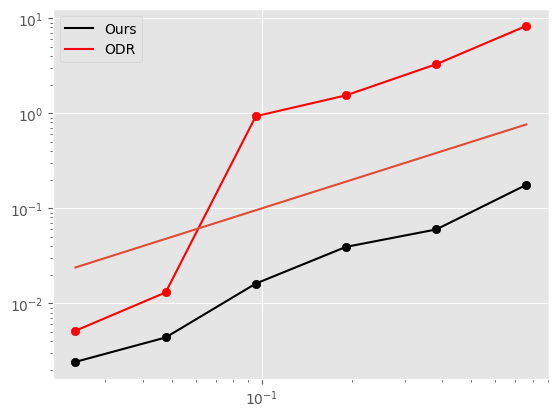

In [34]:
plt.plot(noise_vals/jnp.std(x_train_true),x_errors,c='black',label = "Ours")
plt.scatter(noise_vals/jnp.std(x_train_true),x_errors,c='black')

plt.plot(noise_vals/jnp.std(x_train_true),odr_mean_x,c='red',label = 'ODR')
plt.scatter(noise_vals/jnp.std(x_train_true),odr_mean_x,c='red')


plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))


plt.xscale('log')
plt.yscale('log')


plt.legend()
plt.show()
